<img src="./img/HWNI_logo.svg"/>

# Demo - Sampling Distributions

In [1]:
%matplotlib inline

In [2]:
import collections
import fractions
import functools
import itertools
from operator import __mul__ as mul

import matplotlib.pyplot as plt
import numpy as np

import util.sampdist_demo as demo

Here, we define a few probability mass functions.

Recall from Lab 01 that we can represent a probability mass function with a dictionary,
which works like

```python
dictionary[key] = value
```

The _keys_ of the dictionary are the outcomes, or possible data values.
The _values_ of the dictionary are the probabilities associated with each outcome.

In [3]:
# using fractions here just to make the pmfs look nicer
fair_coin_pmf = {"H": fractions.Fraction(1, 2), "T": fractions.Fraction(1, 2)}

unfair_coin_pmf = {"H": 0.4, "T":0.6}

very_unfair_coin_pmf = {"H": fractions.Fraction(1, 10), "T": fractions.Fraction(9, 10)}

For convenience, we make a variable just to refer to whichever pmf we're currently working with.
That way, if we want to rerun all of the analyses with a different pmf, we can just make a change in this one cell, then go to the `Cell` menu in the toolbar at the top of the screen and select `Run All Below`.

In [4]:
data_pmf = very_unfair_coin_pmf

How do we make a sampling distribution from a `pmf`?

The key assumption for sampling is _independence_: the outcome for one sample has no influence over or predictive power for any other sample.

Independent outcomes have a nice property: the probability of both independent outcomes occuring is the product of the probability of the each outcome individually.

Therefore, the probability of getting a sample is just the product of the `pmf` values for each element in the sample.

The function in the code cell below computes the sampling distribution for a `pmf` in exactly this manner.
It's not necessary to understand everything going on in this function for this demo to be useful.
Lines or blocks that are helpful to understand are preceded by comments.

In [5]:
def make_sampling_distribution_data(pmf, N):
    """
    Parameters
    ----------
    
    pmf                  : dictionary, represents the probability mass function
                           of each data point, with outcomes as keys and
                           probabilities as values
    N                    : int, number of data points in a sample
    
    Returns
    -------
    sampling_distribution_data: dictionary, represents the probability mass
                                function corresponding to the sampling
                                distribution of the data
    """
    # the sampling distribution is also a pmf
    sampling_distribution = {}
    
    labels = pmf.keys()
    
    # every sample is a combo of N labels, every combo is possible
    sample_labels = list(itertools.product(labels, repeat=N))
    
    num_samples = len(sample_labels)
    
    for sample_label in sample_labels:
        
        ps = []
        for label in sample_label:
            # each outcome in the sample has probability pmf[label]
            ps.append(pmf[label])
            
        # the probability of getting a sample is the product of all the outcomes
        sample_probability = 1
        for p in ps:
            sample_probability = sample_probability * p
            
        sampling_distribution[sample_label] = sample_probability
    
    return sampling_distribution

To get rid of any residual air of mystery, here's what the sampling distribution for a small sample according to the `data_pmf` looks like, followed by a plot of the pmf.

In [6]:
small_sample = make_sampling_distribution_data(data_pmf, 4)
[print(key,val) for key, val in small_sample.items()];

('H', 'H', 'H', 'H') 1/10000
('H', 'H', 'H', 'T') 9/10000
('H', 'H', 'T', 'H') 9/10000
('H', 'H', 'T', 'T') 81/10000
('H', 'T', 'H', 'H') 9/10000
('H', 'T', 'H', 'T') 81/10000
('H', 'T', 'T', 'H') 81/10000
('H', 'T', 'T', 'T') 729/10000
('T', 'H', 'H', 'H') 9/10000
('T', 'H', 'H', 'T') 81/10000
('T', 'H', 'T', 'H') 81/10000
('T', 'H', 'T', 'T') 729/10000
('T', 'T', 'H', 'H') 81/10000
('T', 'T', 'H', 'T') 729/10000
('T', 'T', 'T', 'H') 729/10000
('T', 'T', 'T', 'T') 6561/10000


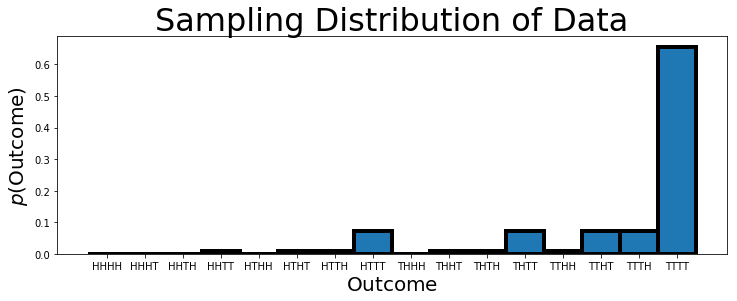

In [7]:
f, ax = plt.subplots(figsize=(12, 4))
demo.plot_sampling_distribution(small_sample, ax=ax,
                                title="Sampling Distribution of Data");

I stuck with just coins so that we could work with sample sizes up to 15.
For a sample size of 15, there are $2^{15}=32,768$ possible samples.
If you define your own pmfs, use the cell below to check that the number of samples isn't too high.

In [8]:
num_outcomes = len(data_pmf)
sample_size = 15

num_possible_samples = num_outcomes ** sample_size

if num_possible_samples > 1e5:
    print("watch out, too many possible samples, might crash: {}".format(num_possible_samples))

## Computing Sampling Distributions of Statistics

Now, we need a function to calculate the sampling distribution of statistics.

Most statistics are non-random -- they don't add randomness of their own to the data (can you think of a counter-example?).
They are just the output of a function, call it $S$, applied to the data.

If the statistic is not random, then the chance of getting a particular value of the statistic, $s$, is equal to the chance of getting _any dataset_ for which $S($dataset$)=s$.

So we can calculate the sampling distribution of the statistic directly from the sampling distribution of the data.
We just work through the sampling distribution, adding up probabilities from samples that share the same value of the statistic.

The function in the cell below implements this procedure, given a `pmf`, a sample size `N`, and a function to calculate the statistic, `statistic calculator`.
See the following code cell for some example `statistic_calculator`s.

Again, the details of this function are much less important than the logic above.
For the curious, the lines that implement the core ideas are preceded by comments.

In [9]:
def make_sampling_distribution_statistic(pmf, N, statistic_calculator):
    """
    Parameters
    ----------
    
    pmf                  : dictionary, represents the probability mass function
                           of each data point, with outcomes as keys and
                           probabilities as values
    N                    : int, number of data points in a sample
    statistic_calculator : function, takes in a sample (list of outcomes), and
                           returns the value of the statistic on that sample
    
    Returns
    -------
    sampling_distribution_statistic : (ordered) dictionary, represents the probability
                                      mass function corresponding to the sampling
                                      distribution of the statistic
    """
    # we need the sampling distribution of the data first
    sampling_distribution_data = make_sampling_distribution_data(pmf, N)
    
    sampling_distribution_statistic = collections.defaultdict(lambda: 0)
    
    # to calculate the pmf of the statistic, iterate through all samples ...
    for sample_label, sample_probability in sampling_distribution_data.items():
        
        # ... calculate the value of the statistic on that sample ...
        statistic_value = statistic_calculator(list(sample_label))
        
        # ... and then add that probability to the pmf for that statistic value
        sampling_distribution_statistic[statistic_value] = (sampling_distribution_statistic[statistic_value]
                                                            + sample_probability)
        
    sampling_distribution_statistic = collections.OrderedDict(
        sorted(sampling_distribution_statistic.items()))
    
    return sampling_distribution_statistic

A `statistic_calculator` must take in a list of outcomes, representing the sample, and return some value.
The only restriction we have here is that the value must be usable as the key to a dictionary. Numbers and strings and `True/False` all work, but a list wouldn't.

In [10]:
def calc_num_heads(tosses):
    return sum([toss == "H" for toss in tosses])

def calc_num_tails(tosses):
    return sum([toss == "T" for toss in tosses])

def calc_is_all_tails(tosses):
    
    if tosses == ["T"]*len(tosses):
        return True
    else:
        return False

Since our outcomes are all strings (`"H"` for heads, `"T"` for tails), we can't use a function like `np.mean` as our statistic calculator, and we need to define a wrapper to first convert tosses to numbers before giving them to the numerical function.

If you define a pmf that has numbers as labels, then you can just use, e.g. `np.mean`, `np.median`.

In [11]:
def calc_mean_coins(tosses):
    return np.mean([toss == "H" for toss in tosses])

Some fun statistics for coin tosses involve the lengths of streaks, or sequences of equal values, like `HHHH` or `TT`.
These take more effort to calculate, so the lion's share has been put into the function `demo.calc_streaks`.
If you're interested in calculating your own statistics for streaks, check out the documentation with `demo.calc_streaks??`.
You might also just try slightly modifying the code in `calc_longest_streak`. To get the shortest streak, you could use `min` instead of `max`, to get the average, you could use `np.mean`, etc.

In [12]:
def calc_longest_streak(tosses):
    streaks = demo.calc_streaks(tosses)
    longest_streak = max([streak_len for label, streak_len in streaks])
    
    return longest_streak

Now, we calculate a bunch of sampling distributions for a variety of statistics on our `data_pmf` with varying numbers of samples.

In [13]:
samp_dist_four_coin_toss_heads = make_sampling_distribution_statistic(data_pmf, 4, calc_num_heads)

In [14]:
samp_dist_four_coin_toss_mean = make_sampling_distribution_statistic(data_pmf, 4, calc_mean_coins)

samp_dist_ten_coin_toss_mean = make_sampling_distribution_statistic(data_pmf, 10, calc_mean_coins)

In [15]:
samp_dist_four_coin_toss_streak = make_sampling_distribution_statistic(data_pmf, 4,
                                                                       calc_longest_streak)

samp_dist_ten_coin_toss_streak = make_sampling_distribution_statistic(data_pmf, 10,
                                                                      calc_longest_streak)

samp_dist_fifteen_coin_toss_streak = make_sampling_distribution_statistic(data_pmf, 15,
                                                                          calc_longest_streak)

In [16]:
samp_dist_four_coin_toss_is_all_tails = make_sampling_distribution_statistic(data_pmf, 4,
                                                                             calc_is_all_tails)

samp_dist_ten_coin_toss_is_all_tails = make_sampling_distribution_statistic(data_pmf, 10,
                                                                             calc_is_all_tails)

samp_dist_fifteen_coin_toss_is_all_tails = make_sampling_distribution_statistic(data_pmf, 15,
                                                                             calc_is_all_tails)

## Visualizing Sampling Distributions of Statistics

Once they're all calculated, we can plot them.

For the smaller samples and the simpler statistics (e.g. "Is All Tails"), try and track where the probability mass in the sampling distribution of the statistic came from by plotting the sampling distribution of the data right next to that of the statistic.

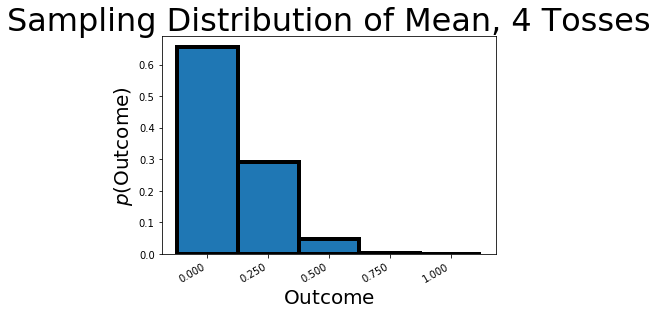

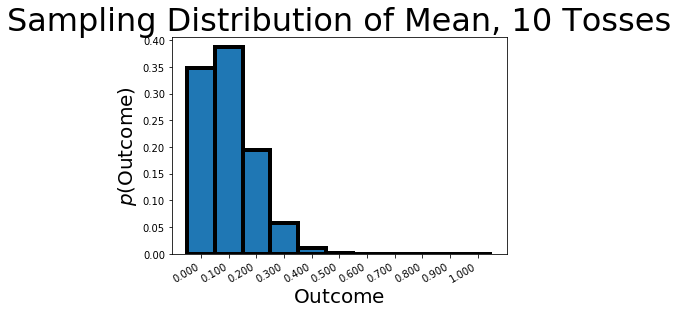

In [17]:
demo.plot_sampling_distribution(samp_dist_four_coin_toss_mean,
                                title="Sampling Distribution of Mean, 4 Tosses");

demo.plot_sampling_distribution(samp_dist_ten_coin_toss_mean,
                                title="Sampling Distribution of Mean, 10 Tosses");

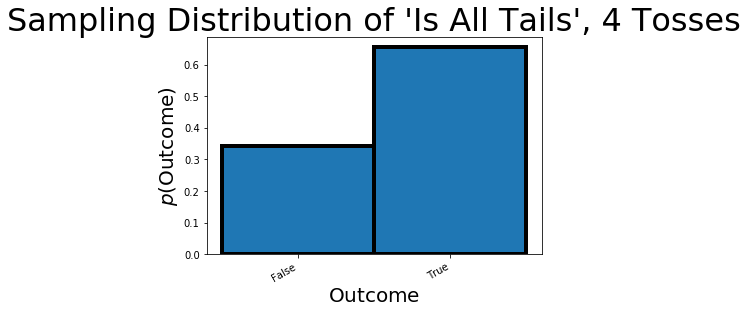

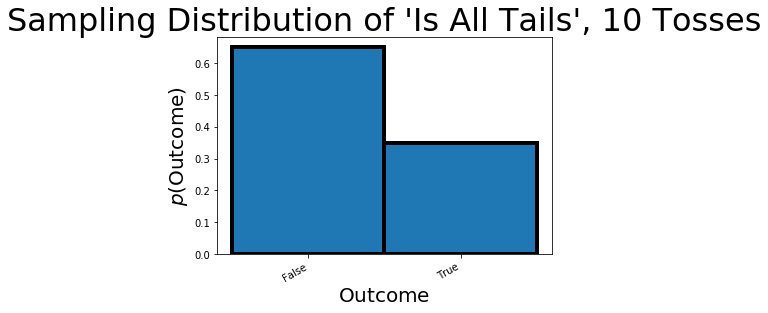

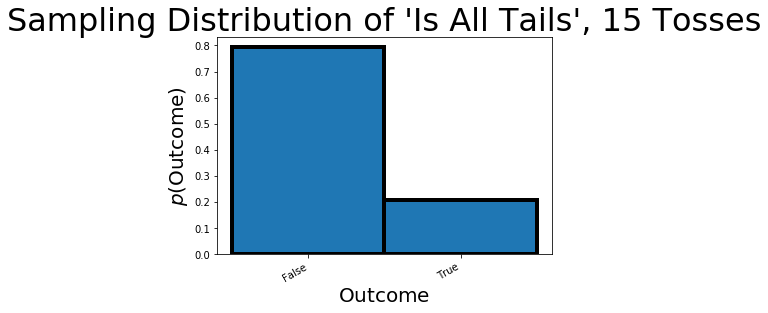

In [18]:
demo.plot_sampling_distribution(samp_dist_four_coin_toss_is_all_tails,
                                title="Sampling Distribution of 'Is All Tails', 4 Tosses");

demo.plot_sampling_distribution(samp_dist_ten_coin_toss_is_all_tails,
                                title="Sampling Distribution of 'Is All Tails', 10 Tosses");

demo.plot_sampling_distribution(samp_dist_fifteen_coin_toss_is_all_tails,
                                title="Sampling Distribution of 'Is All Tails', 15 Tosses");

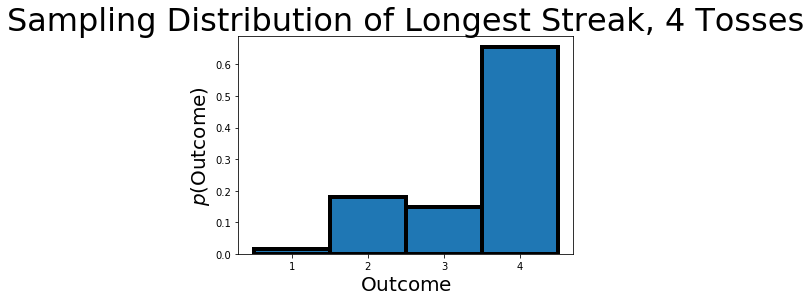

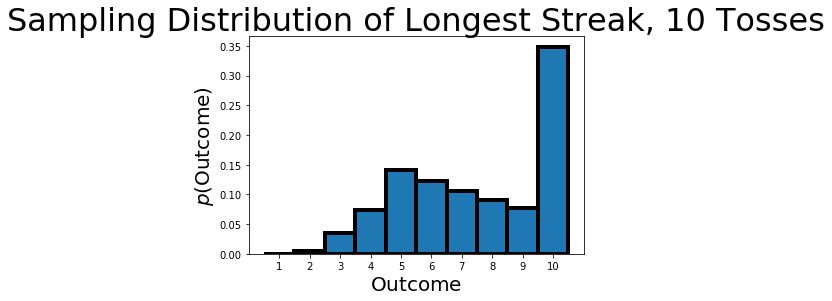

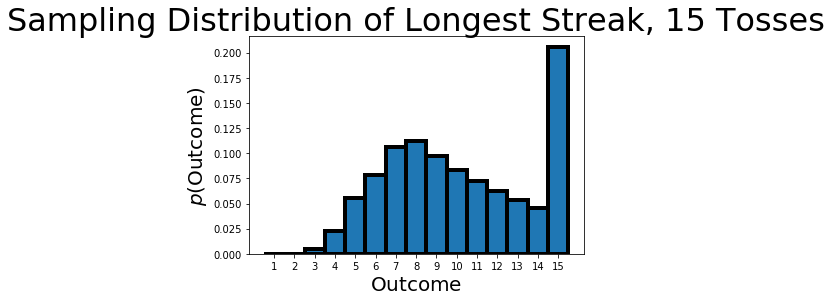

In [19]:
demo.plot_sampling_distribution(samp_dist_four_coin_toss_streak,
                                title="Sampling Distribution of Longest Streak, 4 Tosses");

demo.plot_sampling_distribution(samp_dist_ten_coin_toss_streak,
                                title="Sampling Distribution of Longest Streak, 10 Tosses");

demo.plot_sampling_distribution(samp_dist_fifteen_coin_toss_streak,
                                title="Sampling Distribution of Longest Streak, 15 Tosses");